In [ ]:
from tqdm import tqdm
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
class PresentModified:
    SBOX = [0xc, 0x5, 0x6, 0x1, 0x9, 0x0, 0xa, 0xd,
            0x3, 0xe, 0xf, 0x8, 0x4, 0x7, 0x1, 0x2]
    PBOX = [0, 16, 32, 48, 1, 17, 33, 49,
            2, 18, 34, 50, 3, 19, 35, 51,
            4, 20, 36, 52, 5, 21, 37, 53,
            6, 22, 38, 54, 7, 23, 39, 55,
            8, 24, 40, 56, 9, 25, 41, 57,
            10, 26, 42, 58, 11, 27, 43, 59,
            12, 28, 44, 60, 13, 29, 45, 61,
            14, 30, 46, 62, 15, 31, 47, 63]

    def __init__(self, key: bytes, rounds: int = 32):
        self.rounds = rounds
        self.roundkeys = self._generate_roundkeys(int.from_bytes(key, 'big'))

    def _generate_roundkeys(self, key):
        roundkeys = []
        for i in range(1, self.rounds + 1):
            roundkeys.append(key >> 16)
            key = ((key & (2**19 - 1)) << 61) | (key >> 19)
            sbox_val = self.SBOX[key >> 76]
            key = (sbox_val << 76) | (key & (2**76 - 1))
            key ^= i << 15
        return roundkeys

    def _add_round_key(self, state, roundkey):
        return state ^ roundkey

    def _sbox_layer(self, state):
        output = 0
        for i in range(16):
            output |= self.SBOX[(state >> (i * 4)) & 0xF] << (i * 4)
        return output

    def _p_layer(self, state):
        output = 0
        for i in range(64):
            output |= ((state >> i) & 1) << self.PBOX[i]
        return output

    def encrypt(self, block: bytes) -> bytes:
        state = int.from_bytes(block, 'big')
        for i in range(self.rounds - 1):
            state = self._add_round_key(state, self.roundkeys[i])
            state = self._sbox_layer(state)
            state = self._p_layer(state)
        state = self._add_round_key(state, self.roundkeys[-1])
        return state.to_bytes(8, 'big')

In [ ]:
def encrypt_image(img, cipher):
    encrypted = np.zeros_like(img)
    for ch in range(3):
        for row in range(0, 32, 8):
            for col in range(0, 32, 8):
                block = img[row:row+8, col:col+8, ch].flatten()
                for i in range(8):
                    row_bytes = block[i*8:(i+1)*8]
                    if len(row_bytes) < 8:
                        row_bytes = np.pad(row_bytes, (0, 8-len(row_bytes)), 'constant')
                    encrypted_block = cipher.encrypt(bytes(row_bytes))
                    encrypted[row+i, col:col+8, ch] = list(encrypted_block)
    return encrypted

In [ ]:
import os
random_key = os.urandom(10)
cipher = PresentModified(key=random_key)

In [ ]:
from tqdm import tqdm
x_train_encrypted = np.zeros_like(x_train)
for i in tqdm(range(len(x_train)), desc="Encrypting CIFAR-10"):
    x_train_encrypted[i] = encrypt_image(x_train[i], cipher)

Encrypting CIFAR-10: 100%|██████████| 50000/50000 [3:07:23<00:00,  4.45it/s]


In [ ]:
np.save("x_train_encrypted.npy", x_train_encrypted)
np.save("y_train.npy", y_train)


In [ ]:
np.save("/content/x_train_encrypted_present_mod.npy", x_train_encrypted)
np.save("/content/y_train.npy", y_train)

with open("/content/present_modified_key.bin", "wb") as f:
    f.write(random_key)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
from PIL import Image
output_folder = "/content/drive/MyDrive/Present_cipher_project/encrypted_images"
os.makedirs(output_folder, exist_ok=True)
for i, img in enumerate(x_train_encrypted):
    img_uint8 = Image.fromarray(img.astype(np.uint8))
    img_uint8.save(os.path.join(output_folder, f"{i}.png"))


In [ ]:
import shutil
import os

folder_to_zip = "/content/drive/MyDrive/Present_cipher_project"
zip_output_path = "/content/drive/MyDrive/Present_cipher_project.zip"

if os.path.exists(zip_output_path):
    os.remove(zip_output_path)

shutil.make_archive(base_name=zip_output_path.replace('.zip', ''),
                    format='zip',
                    root_dir=folder_to_zip)

print(f" Successfully created ZIP: {zip_output_path}")


 Successfully created ZIP: /content/drive/MyDrive/Present_cipher_project.zip


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/Present_cipher_project.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

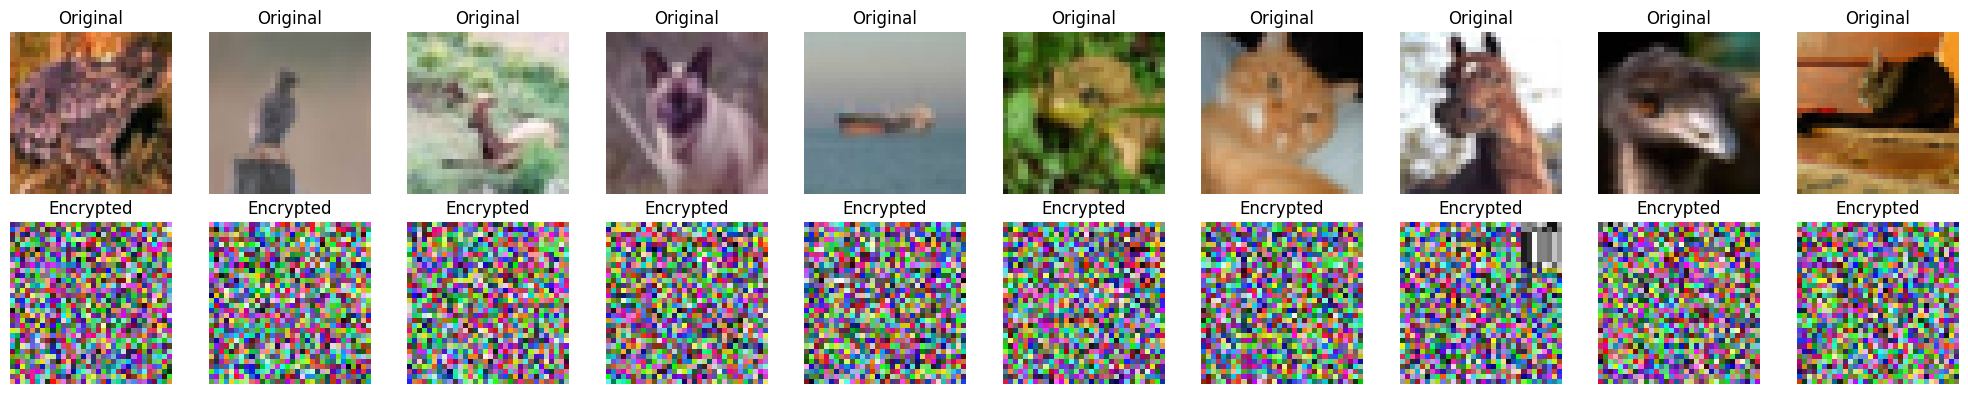

In [ ]:
import matplotlib.pyplot as plt
import random
num_images = 10
indices = random.sample(range(len(x_train_encrypted)), num_images)
plt.figure(figsize=(20, 4))

for i, idx in enumerate(indices):
    e
    plt.subplot(2, num_images, i + 1)
    plt.imshow(x_train[idx])
    plt.title("Original")
    plt.axis('off')


    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(x_train_encrypted[idx])
    plt.title("Encrypted")
    plt.axis('off')

plt.tight_layout()
plt.show()

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

encrypted_img_src = '/content/drive/MyDrive/Present_cipher_project/encrypted_images'
print("Exists:", os.path.exists(encrypted_img_src))
print("Is dir:", os.path.isdir(encrypted_img_src))

Exists: True
Is dir: True


In [ ]:
import zipfile
import os

# Paths
base_dir = "/content/drive/MyDrive/Present_cipher_project"
output_dir = "/content/present_buckets_raw"
os.makedirs(output_dir, exist_ok=True)

zip_map = {
    "present_original.zip": "class_0",
    "present_3to1_cipher.zip": "class_1",
    "present_3to5_cipher.zip": "class_2",
    "present_3to2_cipher.zip": "class_3",
}

# Extract all 4 zips
for zip_name, class_name in zip_map.items():
    zip_path = os.path.join(base_dir, zip_name)
    extract_path = os.path.join(output_dir, class_name)
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f"Extracted {zip_name} to {extract_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Present_cipher_project/present_original.zip'

In [ ]:
for class_name in sorted(os.listdir(input_root)):
    class_path = os.path.join(input_root, class_name)
    images = [img for img in os.listdir(class_path) if img.endswith((".png", ".jpg"))]
    print(f"{class_name}: {len(images)} images")

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Present_cipher_project/present_3to1_cipher.zip"
extract_path = "/content/present_buckets_raw/class_1"

# Clear and re-extract
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Re-extracted class_1 from present_3to1_cipher.zip")


In [ ]:
for class_name in sorted(os.listdir(input_root)):
    class_path = os.path.join(input_root, class_name)
    images = [img for img in os.listdir(class_path) if img.endswith((".png", ".jpg"))]
    print(f"{class_name}: {len(images)} images")


In [ ]:
import shutil
shutil.rmtree("/content/present_buckets_raw/class_1", ignore_errors=True)


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Present_cipher_project/present_3to1_cipher.zip"
extract_path = "/content/present_buckets_raw/class_1"

# Recreate folder
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Re-extracted class_1")


In [ ]:
class_path = "/content/present_buckets_raw/class_1"
images = [img for img in os.listdir(class_path) if img.endswith((".png", ".jpg"))]
print(f"class_1 now has {len(images)} images")


In [ ]:
import zipfile
import shutil
import os

# Clear old class_1 folder (just in case)
extract_path = "/content/present_buckets_raw/class_1"
shutil.rmtree(extract_path, ignore_errors=True)
os.makedirs(extract_path, exist_ok=True)

# Re-extract from the re-uploaded ZIP
zip_path = "/content/drive/MyDrive/Present_cipher_project/present_3to1_cipher.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Re-extracted class_1 from the new ZIP")


In [ ]:
class_path = "/content/present_buckets_raw/class_1"
images = [img for img in os.listdir(class_path) if img.endswith((".png", ".jpg"))]
print(f" class_1 now has {len(images)} images")


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/Present_cipher_project/present_3to1_cipher.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    contents = zip_ref.namelist()
    print(f"📦 ZIP contains {len(contents)} entries")
    print("📁 Sample entries:", contents[:10])


In [ ]:
import zipfile
import shutil
import os

zip_path = "/content/drive/MyDrive/Present_cipher_project/present_3to1_cipher.zip"
extract_path = "/content/present_buckets_raw/class_1"

# Clear previous content
shutil.rmtree(extract_path, ignore_errors=True)
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if member.endswith(".png"):
            # Get filename only (e.g., '0.png') even if it's inside 'encrypted_images/'
            filename = os.path.basename(member)
            if not filename:
                continue
            source = zip_ref.open(member)
            target = open(os.path.join(extract_path, filename), "wb")
            with source, target:
                shutil.copyfileobj(source, target)

print(" Flattened extraction of class_1 completed.")

In [ ]:
class_path = "/content/present_buckets_raw/class_1"
images = [img for img in os.listdir(class_path) if img.endswith(".png")]
print(f" class_1 now has {len(images)} images")


In [ ]:
# Navigate to the folder and zip it
!cd "/content/drive/MyDrive/Present_cipher_project" && zip -r present_3to2_cipher.zip encrypted_images

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Present_cipher_project/present_3to2_cipher.zip"
extract_path = "/content/present_buckets_raw/class_3"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if member.endswith(".png"):
            filename = os.path.basename(member)
            if not filename:
                continue
            source = zip_ref.open(member)
            target = open(os.path.join(extract_path, filename), "wb")
            with source, target:
                shutil.copyfileobj(source, target)

print(" Flattened extraction of class_3 completed.")


In [ ]:
images = os.listdir("/content/present_buckets_raw/class_3")
print(f"class_3 now has {len(images)} images")

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
input_root = "/content/present_buckets_raw"
output_root = "/content/present_buckets_split"
train_dir = os.path.join(output_root, "train")
val_dir = os.path.join(output_root, "val")

# Prepare output dirs
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

val_split = 0.2
max_images = 50000

for class_name in sorted(os.listdir(input_root)):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get only .png or .jpg images, limit to 50k
    images = sorted([img for img in os.listdir(class_path) if img.endswith((".png", ".jpg"))])[:max_images]

    if len(images) == 0:
        print(f"Skipping {class_name} — no images found.")
        continue

    train_imgs, val_imgs = train_test_split(images, test_size=val_split, random_state=42)

    # Create class folders for train/val
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copy train images
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))

    # Copy val images
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_class_dir, img))

    print(f" {class_name}: {len(train_imgs)} train, {len(val_imgs)} val images")

print(" All classes split into train/val successfully.")


In [ ]:
# alexnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

alexnet_model = Sequential([
    Conv2D(96, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(384, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(384, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  #  4 classes
])

alexnet_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "/content/present_buckets_split/train"
val_dir = "/content/present_buckets_split/val"
# Rescale pixels to [0,1]
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=128,
    class_mode='categorical'
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(32, 32),
    batch_size=128,
    class_mode='categorical'
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = alexnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
alexnet_model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=12,   # resume from where you stopped
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
alexnet_model.save("alexnet_present_model.keras")

In [ ]:
val_generator_no_shuffle = datagen.flow_from_directory(
    val_dir,
    target_size=(32, 32),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

alexnet_model.evaluate(val_generator_no_shuffle)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
def build_mobilenet(input_shape=(32, 32, 3), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = mobilenet_block(x, filters=64, strides=1)
    x = mobilenet_block(x, filters=128, strides=2)
    x = mobilenet_block(x, filters=128, strides=1)
    x = mobilenet_block(x, filters=256, strides=2)
    x = mobilenet_block(x, filters=256, strides=1)
    x = mobilenet_block(x, filters=512, strides=2)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [ ]:
mobilenet_model = build_mobilenet()
mobilenet_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [ ]:
history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator_no_shuffle,
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
mobilenet_model.save('/content/mobilenet_present_cipher.keras')

In [ ]:
alexnet_model.save('/content/drive/MyDrive/Present_cipher_project/alexnet_present_cipher.h5')

# Save training history
import pickle

with open('/content/drive/MyDrive/Present_cipher_project/alexnet_history.pkl', 'wb') as f:
    pickle.dump(history_alexnet.history, f)


In [ ]:
mobilenet_model.save('/content/drive/MyDrive/Present_cipher_project/mobilenet_present_cipher.keras')
import pickle
with open('/content/drive/MyDrive/Present_cipher_project/mobilenet_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
alexnet_model.save('/content/drive/MyDrive/Present_cipher_project/alexnet_present_cipher.keras')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Retrain AlexNet and save history properly
history_alexnet = alexnet_model.fit(
    train_generator,
    validation_data=val_generator_no_shuffle,  # no shuffle to match label order
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
import pickle
with open('/content/drive/MyDrive/Present_cipher_project/alexnet_history.pkl', 'wb') as f:
    pickle.dump(history_alexnet.history, f)


In [ ]:
import matplotlib.pyplot as plt

# Step 1: Extract .history if needed
# If alexnet_hist is a History object (not a dict), extract its .history dictionary
if hasattr(alexnet_hist, 'history'):
    alexnet_hist = alexnet_hist.history

# Step 2: Get MobileNet's history
mobilenet_hist = history.history  # assuming `history` is from MobileNet model.fit()

# Step 3: Plot Accuracy and Loss
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(alexnet_hist['accuracy'], label='AlexNet Train', linestyle='--')
plt.plot(alexnet_hist['val_accuracy'], label='AlexNet Val', linestyle='-')
plt.plot(mobilenet_hist['accuracy'], label='MobileNet Train', linestyle='--')
plt.plot(mobilenet_hist['val_accuracy'], label='MobileNet Val', linestyle='-')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(alexnet_hist['loss'], label='AlexNet Train', linestyle='--')
plt.plot(alexnet_hist['val_loss'], label='AlexNet Val', linestyle='-')
plt.plot(mobilenet_hist['loss'], label='MobileNet Train', linestyle='--')
plt.plot(mobilenet_hist['val_loss'], label='MobileNet Val', linestyle='-')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from tensorflow.keras.models import load_model

alexnet_model = load_model('/content/drive/MyDrive/Present_cipher_project/alexnet_present_cipher.keras')
mobilenet_model = load_model('/content/drive/MyDrive/Present_cipher_project/mobilenet_present_cipher.keras')


In [ ]:
!zip -r "/content/drive/MyDrive/Present_cipher_project/present_buckets_split.zip" "/content/present_buckets_split"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_dir = "/content/present_buckets_split/val"

datagen = ImageDataGenerator(rescale=1./255)
val_generator_no_shuffle = datagen.flow_from_directory(
    val_dir,
    target_size=(32, 32),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
import numpy as np

# Load all validation data from the generator
X_test, y_test = [], []

for i in range(len(val_generator_no_shuffle)):
    x_batch, y_batch = val_generator_no_shuffle[i]
    X_test.append(x_batch)
    y_test.append(y_batch)

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Class labels
class_names = ['PRESENT', '3→2 S-box', '3→5 S-box', '3→1 S-box']

# Get predictions from both models
y_pred_alexnet = np.argmax(alexnet_model.predict(X_test), axis=1)
y_pred_mobilenet = np.argmax(mobilenet_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot 10 random images with both predictions
plt.figure(figsize=(20, 10))
for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = int(y_true[idx])
    pred_alex = int(y_pred_alexnet[idx])
    pred_mobilenet = int(y_pred_mobilenet[idx])

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    title = f"True: {class_names[true_label]}\nAlexNet: {class_names[pred_alex]}\nMobileNet: {class_names[pred_mobilenet]}"
    color = "green" if (pred_alex == true_label and pred_mobilenet == true_label) else "red"
    plt.title(title, color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig("alexnet_vs_mobilenet_predictions.png")
plt.show()
